In [ ]:
%matplotlib inline
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch 
import numpy as np
import pandas as pd
import pickle
import accelerate
import os
import re 
import glob
from tqdm import tqdm
from torch.nn import functional as F
import argparse
import sys
sys.path.append('/work/09192/jianing/ls6/Memory_generation')
from attention_head_detection import *

In [8]:
# custom head detection 
save_dir = '/work/09192/jianing/ls6/Memory_generation/generated'

model_to_path_dict={
        'Llama-2-13b-chat-hf':{
            'hf_name':"meta-llama/Llama-2-13b-chat-hf",
            'save_dir_name':"llama2-chat",
            'initial_char':'▁',
        },
        'gemma-7b':{
            'hf_name':"google/gemma-7b",
            'save_dir_name':'gemma-7b',
            'initial_char':None,
        },
        'Llama3-8b-instruct':{
            'hf_name':"meta-llama/Meta-Llama-3-8B-Instruct",
            'save_dir_name':'llama3-8b-instruct',
            'initial_char':'Ġ',
        }
}
model_name = 'Llama3-8b-instruct'
#model_name = 'gemma-7b'
model_save_dir_name = model_to_path_dict[model_name]['save_dir_name']
model_initial_char = model_to_path_dict[model_name]['initial_char']
tokenizer = AutoTokenizer.from_pretrained(model_to_path_dict[model_name]['hf_name'])
attention_head_output_dir = os.path.join(save_dir,model_save_dir_name,'attention_head_test')
model = AutoModelForCausalLM.from_pretrained(model_to_path_dict[model_name]['hf_name'],device_map='auto',torch_dtype = torch.float16)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
induction_prompt1 = "there're some scientists who say that the universe that we inhabit is not the only universe there is there are alternate universes they say that these universes arise from the sub atomic realm of quantum physics here's how they say it works every time a quantum event happens it produces all of its possible results this is like saying if you flip a coin it comes up heads but it also comes up tails since those two results are mutually exclusive the flipping of the coin splits the universe into two alternate universes the heads universe and the tails universe and"
induction_prompt2 = "i began my illustrious career in journalism in the bronx where i toiled as a hard boiled reporter for the ram the student newspaper at fordham university and one day i'm walking toward the campus center and out comes the elusive dean mcgowan architect of a policy to replace fordham's traditionally working to middle class students with wealthier more prestigious ones so i whip out my notebook and i go up to him and i say dean mcgowan is it true that fordham university plans to raise tuition substantially above the inflation rate and if so wouldn't that be a betrayal of its mission"
induction_prompt3 = "under the influence is our topic tonight and uh i i thought of a lot of different things and and the one i kinda wanted to talk about was my secret influence um there are people in our lives that are incredibly important to us and i would even m mention to say some of the most important people everybody aside from my mother in my life doesn't know anything about this person who i think about every day and his name was michael marquis so if this were a violin piece it would be called ode to michael marquis"

In [10]:
induction_tokens = []
repeat_start_indices = []
for prompt in [induction_prompt1,induction_prompt2,induction_prompt3]:
    tokens_start = tokenizer(prompt, return_tensors="pt").input_ids
    tokens_repeat = tokenizer(prompt, return_tensors="pt",add_special_tokens = False).input_ids
    tokens = torch.concat([tokens_start,tokens_repeat,tokens_repeat],dim = 1)
    induction_tokens.append(tokens)
    repeat_start_indices.append([tokens_start.shape[1],torch.concat([tokens_start,tokens_repeat],dim = 1).shape[1]])
induction_stimuli={'tokens':induction_tokens,'repeat_start_indices':repeat_start_indices}
if not os.path.exists(attention_head_output_dir):
    os.makedirs(attention_head_output_dir)
with open(os.path.join(attention_head_output_dir,'induction_tokens.pkl'),'wb') as f:
    pickle.dump(induction_stimuli,f)

In [11]:
with open(os.path.join(attention_head_output_dir,'induction_tokens.pkl'),'rb') as f:
    induction_stimuli = pickle.load(f)

device = "cuda" if torch.cuda.is_available() else "cpu"
all_head_scores =[]
for input_tokenized in tqdm(induction_stimuli['tokens']):
    with torch.no_grad():
        output = model(input_tokenized.to(device),return_dict = True,output_attentions = True)
    attentions = output['attentions']
    head_scores = detect_head(model_to_path_dict[model_name]['hf_name'],detection_pattern='induction_head',
        attentions=attentions,
        tokens=input_tokenized.to(device))
    all_head_scores.append(head_scores)

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
with open(os.path.join(attention_head_output_dir,'prompt3_attention.pkl'),'wb') as f:
    pickle.dump(attentions,f)

In [12]:
def plt_head_scores(head_scores,model_name,head_name):
    plt.figure()
    plt.imshow(head_scores,vmin=0, vmax=1)
    plt.colorbar()
    plt.xlabel('Head')
    plt.ylabel('Layer')
    plt.title('%s head matches, %s'%(head_name,model_name))

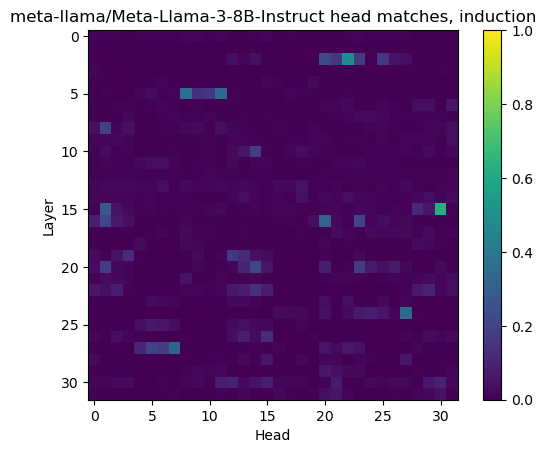

In [13]:
mean_head_scores = torch.mean(torch.stack(all_head_scores),axis =0)
plt_head_scores(mean_head_scores,'induction',model_to_path_dict[model_name]['hf_name'])

In [14]:
mean_head_scores = mean_head_scores.cpu().numpy()
ind = np.unravel_index(np.argsort(mean_head_scores, axis=None), mean_head_scores.shape)

In [15]:
with open(os.path.join(attention_head_output_dir,'mean_head_scores.npy'), 'wb') as f:
    np.save(f, mean_head_scores)

In [16]:
print('top 10 heads:')
for i in range(len(ind[0])-1,len(ind[0])-10,-1):
    print('layer:',ind[0][i],'head:',ind[1][i])
    print(mean_head_scores[ind[0][i],ind[1][i]])

top 10 heads:
layer: 15 head: 30
0.62757784
layer: 2 head: 22
0.48678312
layer: 5 head: 8
0.35911036
layer: 5 head: 11
0.35084724
layer: 24 head: 27
0.34410405
layer: 27 head: 7
0.32211706
layer: 16 head: 20
0.30734316
layer: 15 head: 1
0.28108442
layer: 2 head: 20
0.21949345


In [18]:
layer = 15
head = 30
this_att_head = attentions[layer][0,head].detach().cpu().numpy()

In [21]:
print(induction_stimuli['repeat_start_indices'][-1])

[103, 205]


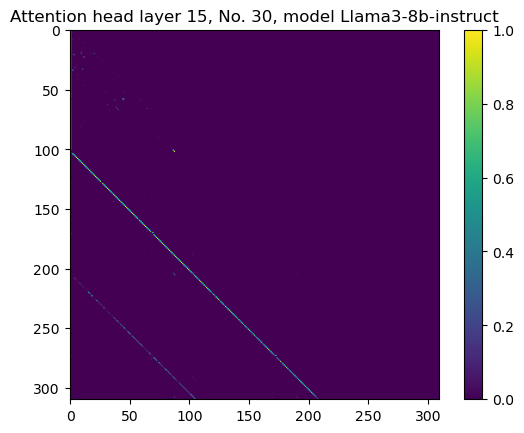

In [19]:
# indeed an induction head! 
plt.imshow(this_att_head)
plt.title('Attention head layer %s, No. %s, model %s'%(layer,head,model_name))
plt.colorbar()

In [21]:
with open(os.path.join(attention_head_output_dir,'induction_tokens.pkl'),'rb') as f:
    induction_stimuli = pickle.load(f)

device = "cuda" if torch.cuda.is_available() else "cpu"
all_head_scores =[]
for input_tokenized in tqdm(induction_stimuli['tokens']):
    with torch.no_grad():
        output = model(input_tokenized.to(device),return_dict = True,output_attentions = True)
    attentions = output['attentions']
    head_scores = detect_head(model_to_path_dict[model_name]['hf_name'],detection_pattern='duplicate_token_head',
        attentions=attentions,
        tokens=input_tokenized.to(device))
    all_head_scores.append(head_scores)

  0%|          | 0/3 [00:00<?, ?it/s]

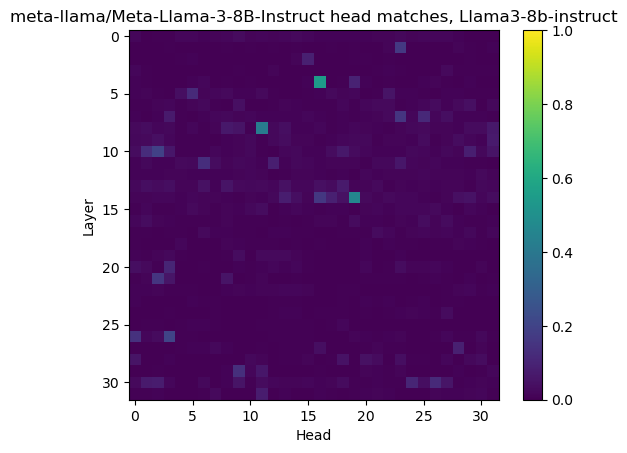

In [23]:
mean_head_scores = torch.mean(torch.stack(all_head_scores),axis =0)
head_name = 'duplicate token'
plt_head_scores(mean_head_scores,model_name,model_to_path_dict[model_name]['hf_name'])

In [24]:
mean_head_scores = mean_head_scores.cpu().numpy()
ind = np.unravel_index(np.argsort(mean_head_scores, axis=None), mean_head_scores.shape)

In [25]:
with open(os.path.join(attention_head_output_dir,'mean_duplicate_token_head_scores.npy'), 'wb') as f:
    np.save(f, mean_head_scores)

In [27]:
print('top 10 heads:')
for i in range(len(ind[0])-1,len(ind[0])-10,-1):
    print('layer:',ind[0][i],'head:',ind[1][i])
    print(mean_head_scores[ind[0][i],ind[1][i]])

top 10 heads:
layer: 4 head: 4
0.65826297
layer: 7 head: 1
0.43058935
layer: 1 head: 2
0.4058121
layer: 11 head: 7
0.37165216
layer: 14 head: 0
0.35974565
layer: 15 head: 7
0.35158026
layer: 0 head: 6
0.3261421
layer: 6 head: 10
0.27544442
layer: 7 head: 14
0.27518615
